<a href="https://colab.research.google.com/github/iamrosan/Fake-News-Detection-BCT-Mini-Project-/blob/lstm-keras/lstm_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from keras.preprocessing import text,sequence

from sklearn.model_selection import train_test_split

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Model configuration
# additional_metrics = ['accuracy']
# batch_size = 128
# embedding_output_dims = 15
# loss_function = BinaryCrossentropy()
# max_sequence_length = 83674
# num_distinct_words = 5000
# number_of_epochs = 5
# optimizer = Adam()
# validation_split = 0.20
# verbosity_mode = 1

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Disable eager execution
# tf.compat.v1.disable_eager_execution()
# import pandas as pd
# import numpy as np

In [ ]:
df_true = pd.read_csv('/content/drive/MyDrive/ProcessedData/processedTrue.csv')
df_fake = pd.read_csv('/content/drive/MyDrive/ProcessedData/processedFake.csv')

In [ ]:
print(df_true.size)
print(df_fake.size)

64251
70380


In [ ]:
df = pd.concat([df_true, df_fake])

In [ ]:
df.head()

,Unnamed: 0,label,content
0,0,0,u budget fight loom republicans flip fiscal sc...
1,1,0,u military accept transgender recruit monday p...
2,2,0,senior u republican senator let mr mueller job...
3,3,0,fbi russia probe help australian diplomat tip ...
4,4,0,trump want postal service charge much amazon s...


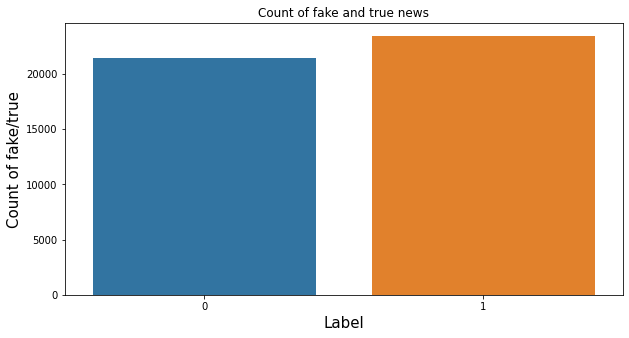

In [ ]:
ax=sns.countplot(x="label", data=df)

#Setting labels and font size
ax.set(xlabel='Label', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



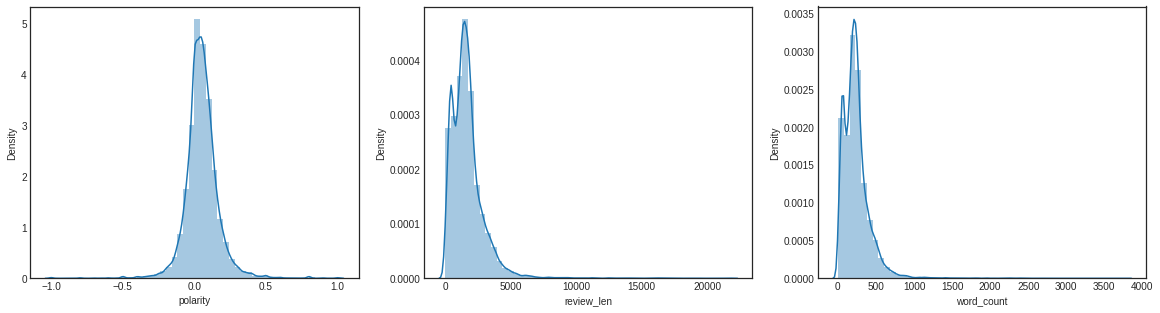

In [ ]:
#Extracting the features from the news
df['polarity'] = df['content'].map(lambda text: TextBlob(text).sentiment.polarity)
df['review_len'] = df['content'].astype(str).apply(len)
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(df['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(df['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(df['word_count'])
fig = plt.gcf()

N-gram Analysis

In [ ]:
#Function to get top n words
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(df['content'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['content' , 'count'])

#Group by words and plot the sum
df1.groupby('content').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in content')

say 173885
trump 148730
state 64214
president 57363
would 55437
people 42453
make 40421
one 38319
go 34672
new 32814
take 32257
house 31659
obama 31346
tell 31092
also 31065
clinton 30200
time 29806
reuters 29554
donald 28952
get 28646


In [ ]:
#Function to get top bigram words
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_bigram(df['content'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)
    
#Creating the dataframe of word and frequency
df3 = pd.DataFrame(common_words, columns = ['content' , 'count'])

#Group by words and plot the sum
df3.groupby('content').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 bigrams in content')

donald trump 27247
unite state 18827
white house 16248
hillary clinton 10114
new york 9245
feature image 7779
north korea 7367
president donald 6992
washington reuters 6678
twitter com 6565
image via 6344
trump say 6265
pic twitter 6146
barack obama 5769
year old 5096
president trump 5094
prime minister 4862
last week 4751
last year 4751
supreme court 4681


In [ ]:
#Function to get top trigram words
def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_trigram(df['content'], 20)

#Printing word and their respective frequencies
for word, freq in common_words:
    print(word, freq)

#Creating a dataframe with words and count
df6 = pd.DataFrame(common_words, columns = ['content' , 'count'])

#Grouping the words and plotting their frequencies
df6.groupby('content').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 trigrams in content')

president donald trump 6930
pic twitter com 6146
president barack obama 3901
new york time 2143
donald trump realdonaldtrump 1790
reuters president donald 1565
black live matter 1535
washington reuters president 1533
white house say 1237
president unite state 1195
elect donald trump 1177
president elect donald 1115
new york city 1051
president vladimir putin 977
news century wire 941
donald trump say 940
national security adviser 921
affordable care act 907
director jam comey 883
respond request comment 882


Word Cloud of True/Fake news

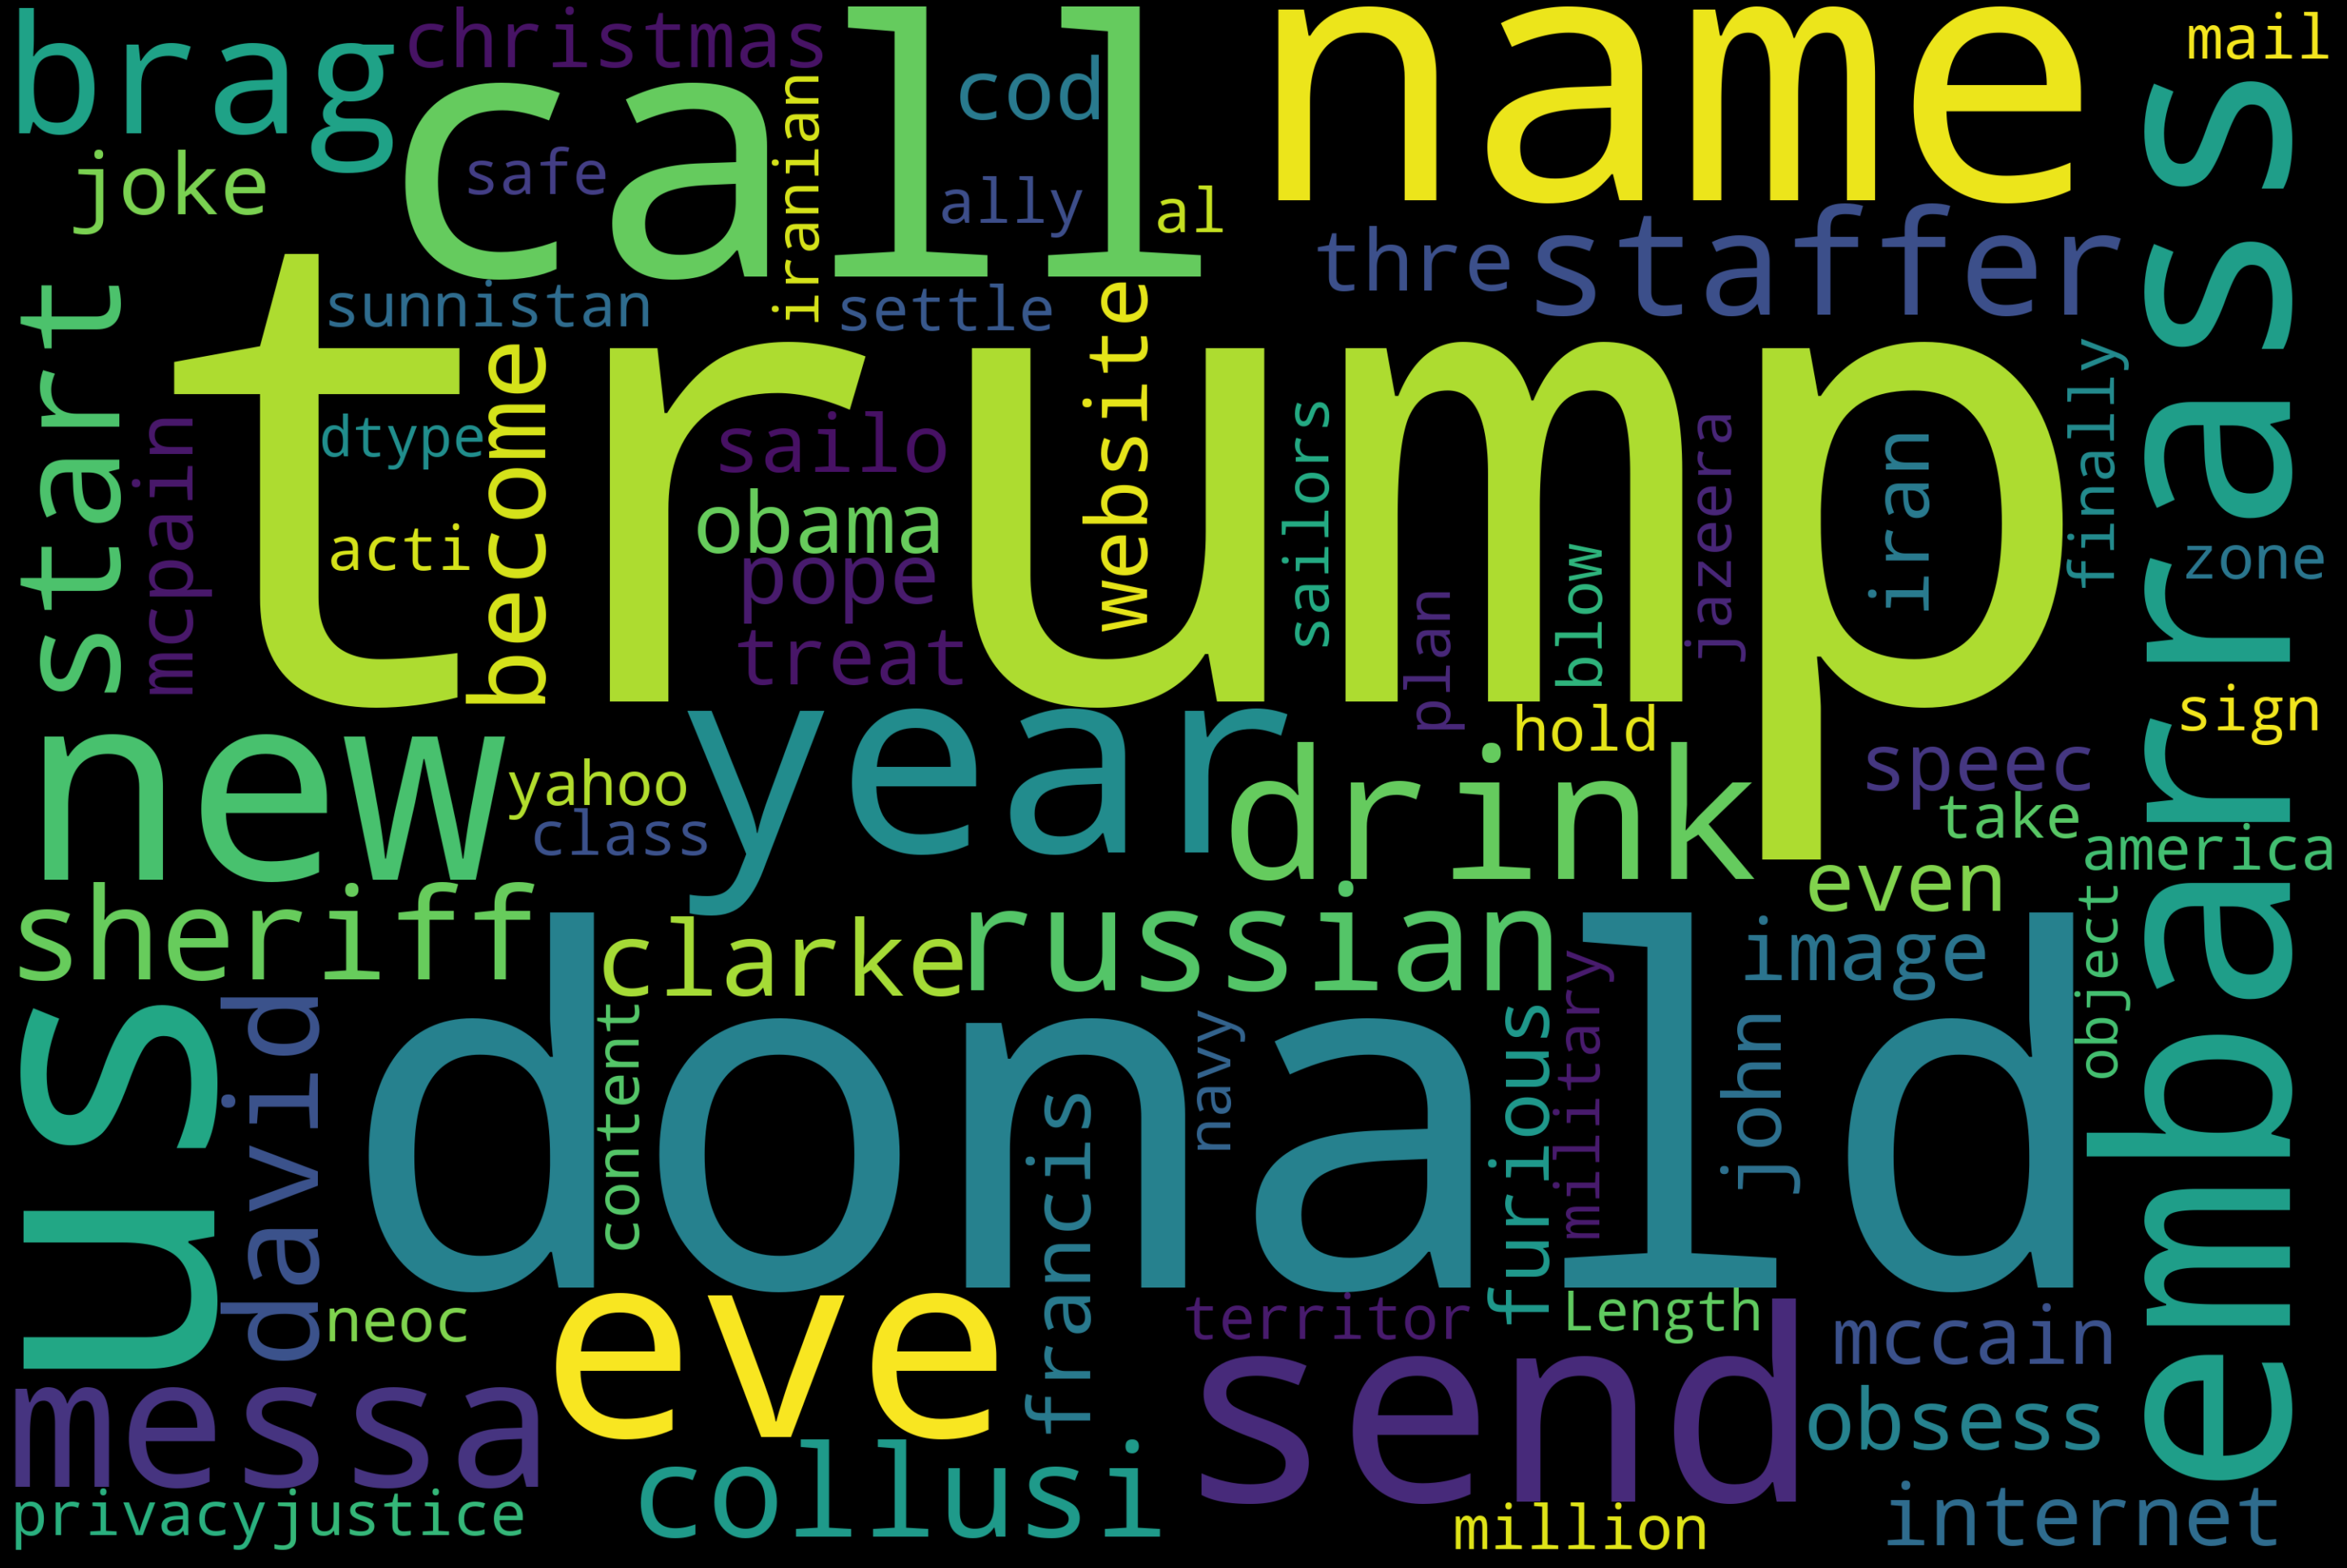

In [ ]:
text = df_fake["content"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

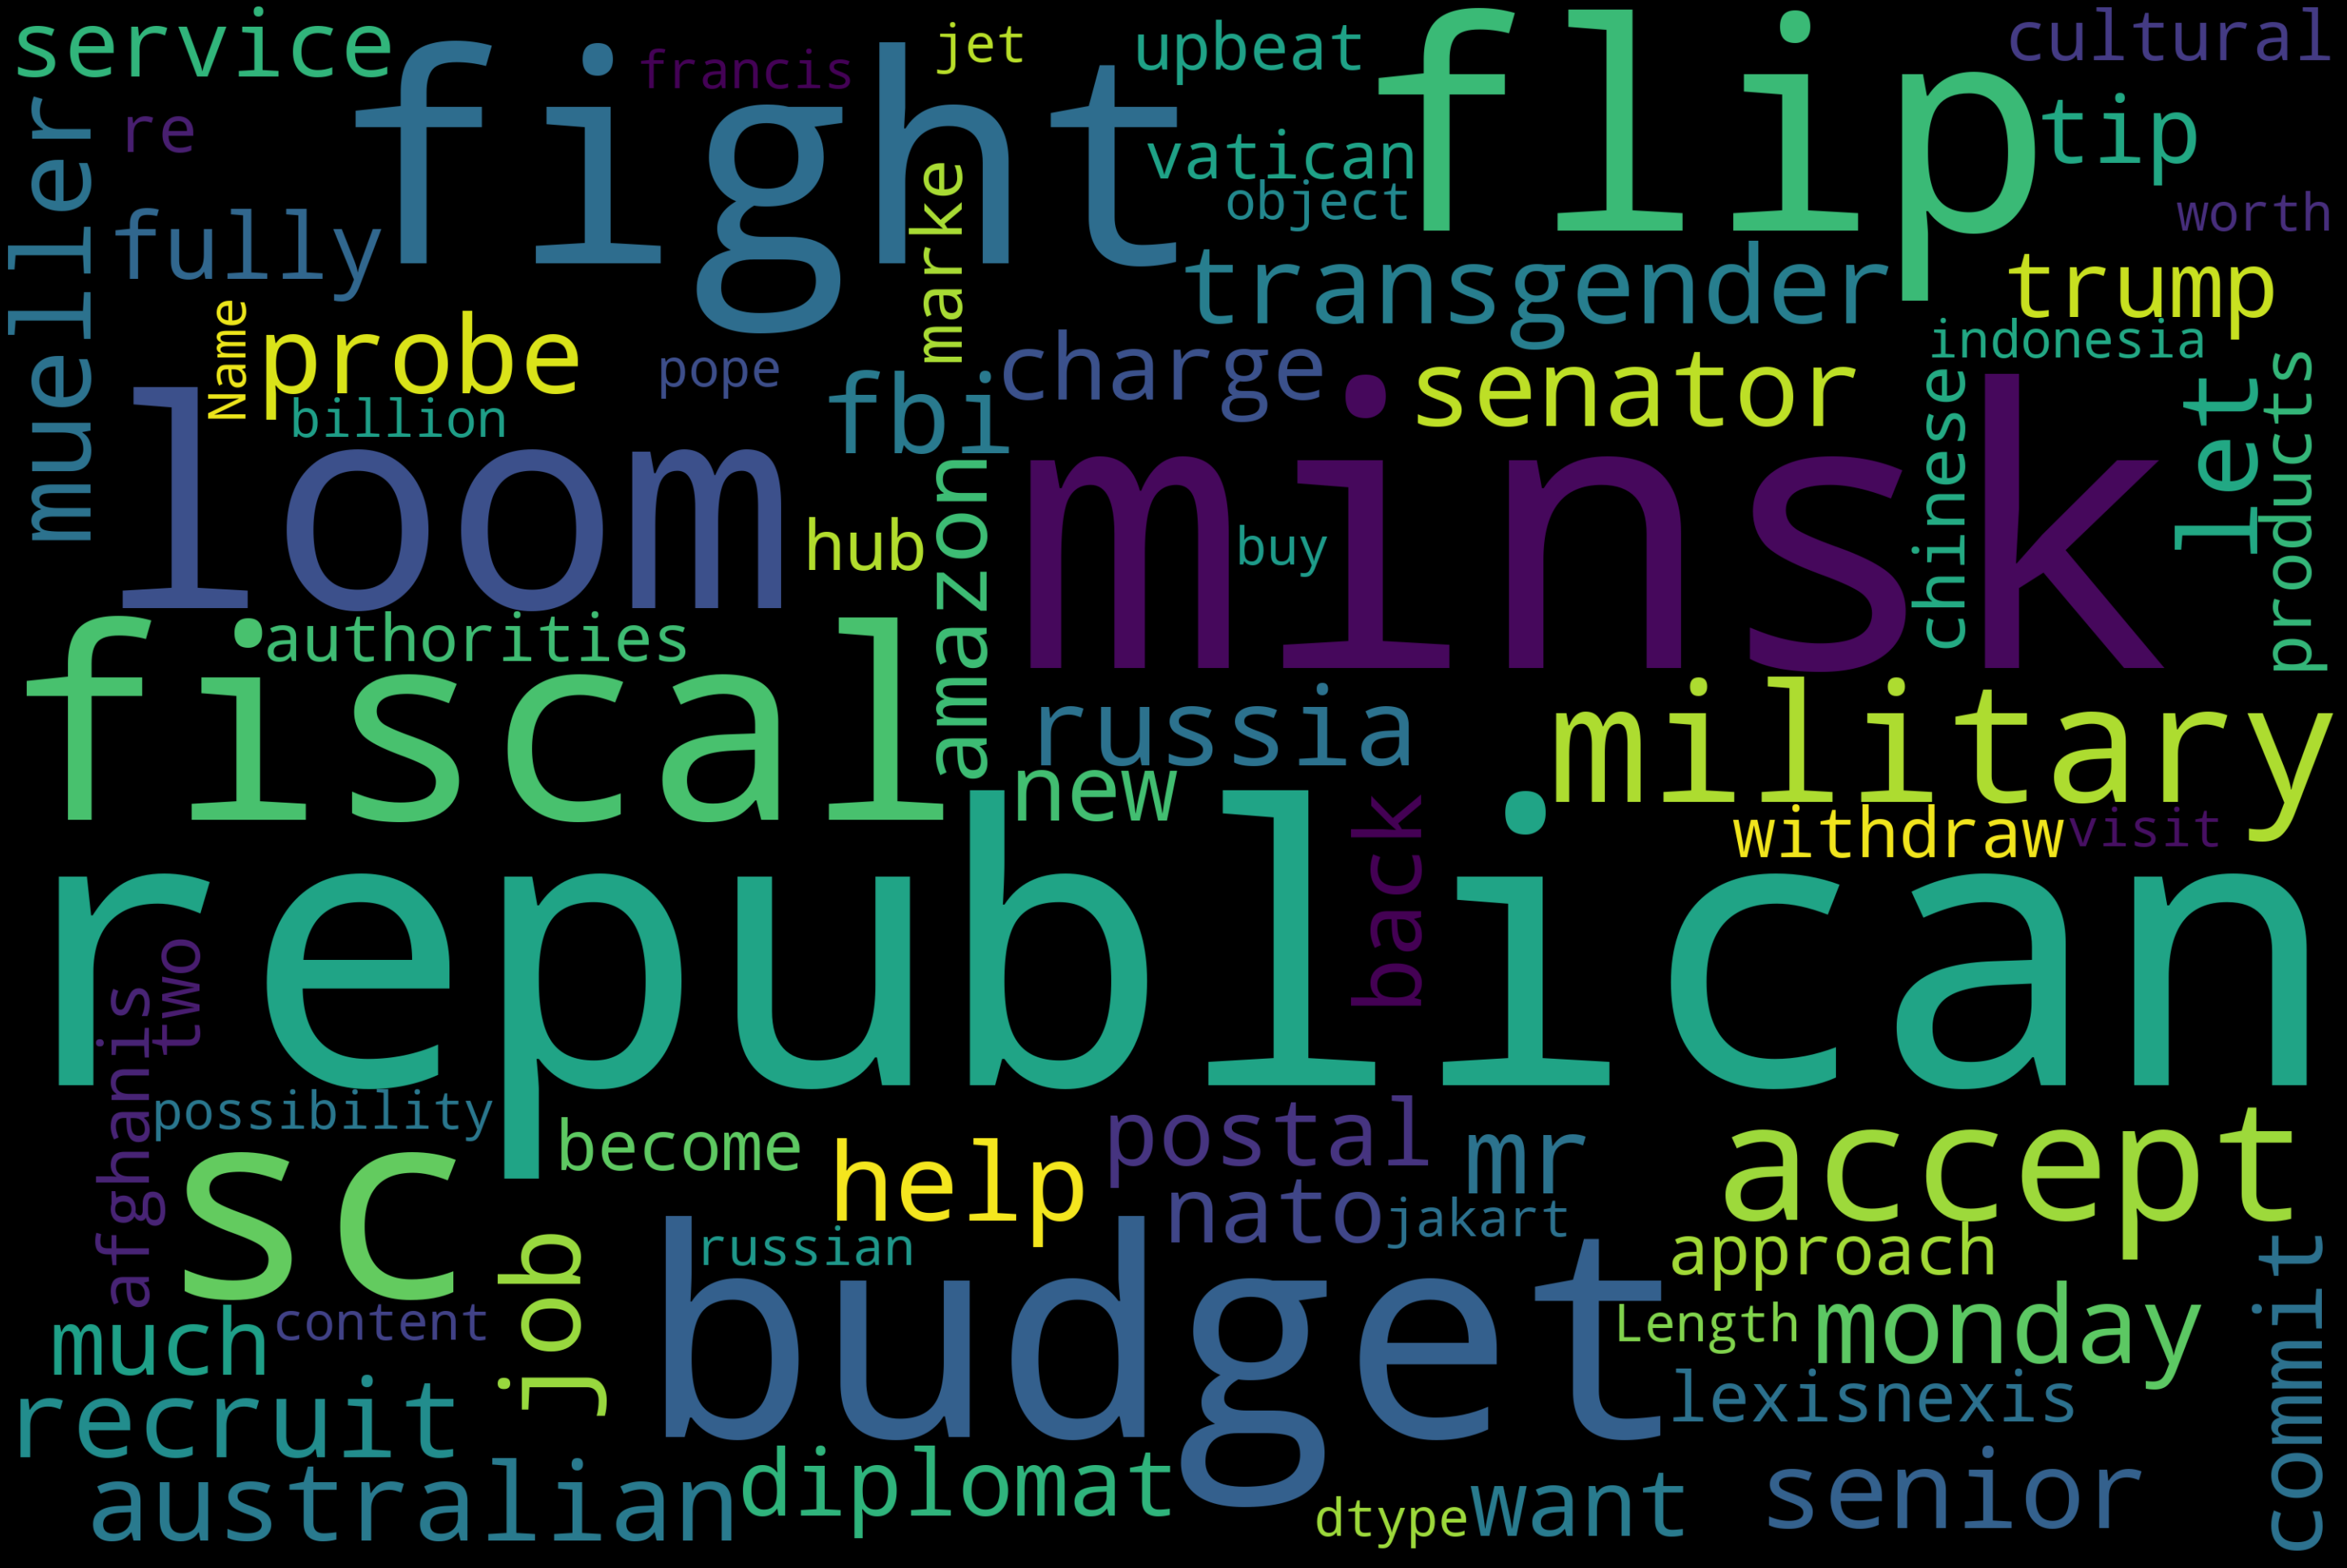

In [ ]:
text = df_true["content"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()



In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(df['content'])
X.shape



(44877, 300)

In [ ]:
# X = df['content']
y = df.label

In [ ]:
print(f'Original dataset shape : {Counter(y)}')

Original dataset shape : Counter({1: 23460, 0: 21417})


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=42)
# Load dataset
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=num_distinct_words)

In [ ]:
#Extracting 'content' for processing
news_features=df.copy()
news_features=news_features[['content']].reset_index(drop=True)
news_features.head()

,content
0,u budget fight loom republicans flip fiscal sc...
1,u military accept transgender recruit monday p...
2,senior u republican senator let mr mueller job...
3,fbi russia probe help australian diplomat tip ...
4,trump want postal service charge much amazon s...


In [ ]:
corpus = []
for i in range(0, len(news_features)):
  news = re.sub('[^a-zA-Z]', ' ', news_features['content'][i])
  news= news.lower()
  news = news.split()
  news = ' '.join(news)
  corpus.append(news) 

In [ ]:
corpus[1]

'u military accept transgender recruit monday pentagon washington reuters transgender people allow first time enlist u military start monday order federal court pentagon say friday president donald trump administration decide appeal rule block transgender ban two federal appeal court one washington one virginia last week reject administration request put hold order lower court judge require military begin accept transgender recruit jan justice department official say administration challenge rule department defense announce release independent study issue come weeks rather litigate interim appeal occur administration decide wait dod study continue defend president lawful authority district court meantime official say speak condition anonymity september pentagon say create panel senior officials study implement directive trump prohibit transgender individuals serve defense department feb submit plan trump lawyers represent currently serve transgender service members aspire recruit say e

In [ ]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

Padding documents

In [ ]:
#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ...  255 2705 8344]
 [   0    0    0 ...   87 3317 6930]
 [   0    0    0 ... 6697 2587 1248]
 ...
 [   0    0    0 ...  107 1811 5348]
 [   0    0    0 ...  107 8815 5015]
 [   0    0    0 ...  107 7548 5348]]


In [ ]:
embedded_docs[1]

array([   0,    0,    0, ...,   87, 3317, 6930], dtype=int32)

Bidirectionsl LSTM

In [ ]:
# Creating bidirectional lstm model
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) # Bidirectional LSTM layer
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5000, 40)          400000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 513,001
Trainable params: 513,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
len(embedded_docs),y.shape

(44877, (44877,))

In [ ]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44877, 5000), (44877,))

In [ ]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
# model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)



In [ ]:
# import pickle
# #create an iterator object with write permission - model.pkl
# with open('newModel.pkl', 'wb') as files:
#     pickle.dump(model1, files)

INFO:tensorflow:Assets written to: ram://a26477ef-a94f-4717-b3fb-887415ba404d/assets


INFO:tensorflow:Assets written to: ram://a26477ef-a94f-4717-b3fb-887415ba404d/assets


In [ ]:
#load saved model
import pickle
with open('/content/drive/MyDrive/newModel.pkl' , 'rb') as f:
    lr = pickle.load(f)

# with open('/content/drive/MyDrive/model1.pkl' , 'rb') as f:
#     lr = pickle.load(f)

In [ ]:
# Predicting from test dataset
y_pred1=lr.predict(X_test)

In [ ]:
# Test the model after training
# test_results = lr.evaluate(X_test, y_test, verbose=False)
# print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

In [ ]:
p_pred = y_pred1.flatten()
print(p_pred.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[1.   0.98 1.   ... 0.99 1.   1.  ]
[1 1 1 ... 1 1 1]


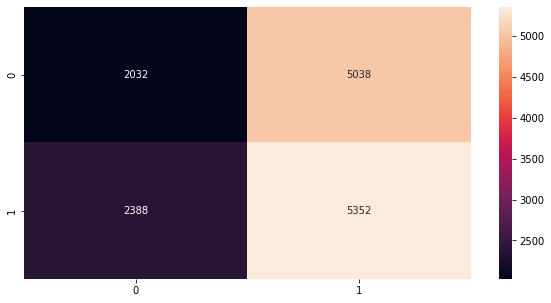

In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
# cm = metrics.confusion_matrix(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred1)
f = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# Creating classification report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.46      0.29      0.35      7070
           1       0.52      0.69      0.59      7740

    accuracy                           0.50     14810
   macro avg       0.49      0.49      0.47     14810
weighted avg       0.49      0.50      0.48     14810



In [ ]:
#Checking for accuracy
# accuracy_score(y_test,y_pred1)

0.49858203916272786

Second Model

In [ ]:
X = df['content']
y = df.label

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=.2,
                                                    random_state=42)

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf_vectorizer = TfidfVectorizer(stop_words='english')
# X_train = tfidf_vectorizer.fit_transform(X_train) 
# X_test = tfidf_vectorizer.transform(X_test)

In [ ]:
# print(xv_train)

In [ ]:
# # Pad all sequences
# padded_inputs = pad_sequences(xv_train, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>
# padded_inputs_test = pad_sequences(xv_test, maxlen=max_sequence_length, value = 0.0) # 0.0 because it corresponds with <PAD>


In [ ]:
max_features = 10000
max_len = 300
batch_size = 256
epochs = 10
embed_size = 100

In [ ]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=max_len)

In [ ]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=max_len)

In [ ]:
print(X_test)

[[   0    0    0 ...   12  365 3284]
 [   0    0    0 ...  110   93  318]
 [   0    0    0 ...  318  968   40]
 ...
 [   0    0    0 ...  427 5863 1263]
 [   0    0    0 ...  170   77 1197]
 [   0    0    0 ...  224 1120   41]]


In [ ]:
# Define the Keras model
# model1=Sequential()
# model1.add(Embedding(max_features, output_dim=embed_size, input_length=max_len, trainable=False, mask_zero = True))
# model1.add(Dropout(0.7))
# model1.add(Bidirectional(LSTM(100)))
# model1.add(Dense(1,activation='sigmoid'))
# model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
# print(model1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 100)          1000000   
                                                                 
 dropout (Dropout)           (None, 300, 100)          0         
                                                                 
 bidirectional (Bidirectiona  (None, 200)              160800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 1,161,001
Trainable params: 161,001
Non-trainable params: 1,000,000
_________________________________________________________________
None


In [ ]:
# Train the model
# history = model1.fit(X_train, y_train, batch_size=batch_size, epochs=10, verbose=1, validation_split=0.3)


Epoch 1/10
93/93 [==============================] - 229s 2s/step - loss: 0.6163 - accuracy: 0.6984 - val_loss: 0.4668 - val_accuracy: 0.8353
Epoch 2/10
93/93 [==============================] - 217s 2s/step - loss: 0.4220 - accuracy: 0.8084 - val_loss: 0.2702 - val_accuracy: 0.9118
Epoch 3/10
93/93 [==============================] - 210s 2s/step - loss: 0.3372 - accuracy: 0.8516 - val_loss: 0.2567 - val_accuracy: 0.8953
Epoch 4/10
93/93 [==============================] - 211s 2s/step - loss: 0.3015 - accuracy: 0.8640 - val_loss: 0.2288 - val_accuracy: 0.9039
Epoch 5/10
93/93 [==============================] - 214s 2s/step - loss: 0.2783 - accuracy: 0.8781 - val_loss: 0.1720 - val_accuracy: 0.9345
Epoch 6/10
93/93 [==============================] - 213s 2s/step - loss: 0.2301 - accuracy: 0.9017 - val_loss: 0.1582 - val_accuracy: 0.9366
Epoch 7/10
93/93 [==============================] - 211s 2s/step - loss: 0.2169 - accuracy: 0.9058 - val_loss: 0.1660 - val_accuracy: 0.9240
Epoch 8/10
93

In [ ]:
# import pickle
# #create an iterator object with write permission - model.pkl
# with open('model1.pkl', 'wb') as files:
#     pickle.dump(model1, files)

INFO:tensorflow:Assets written to: ram://ae27f5c9-890c-4779-add5-8689ce0bb6db/assets


INFO:tensorflow:Assets written to: ram://ae27f5c9-890c-4779-add5-8689ce0bb6db/assets


In [ ]:
# Test the model after training
test_results = lr.evaluate(X_test, y_test, verbose=False)
print(f'Test results - Loss: {test_results[0]} - Accuracy: {100*test_results[1]}%')

Test results - Loss: 0.16964223980903625 - Accuracy: 93.30436587333679%


In [ ]:
# load saved model
import pickle
with open('/content/drive/MyDrive/model1.pkl' , 'rb') as f:
    lr = pickle.load(f)

In [ ]:
# Predicting from test dataset
y_pred1=lr.predict(X_test)

In [ ]:
p_pred = y_pred1.flatten()
print(p_pred.round(2))
# [1. 0.01 0.91 0.87 0.06 0.95 0.24 0.58 0.78 ...

# extract the predicted class labels
y_pred = np.where(p_pred > 0.5, 1, 0)
print(y_pred)

[0.   0.88 0.52 ... 0.35 0.67 0.01]
[0 1 1 ... 0 1 0]


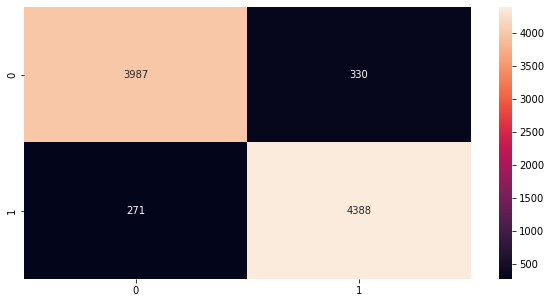

In [ ]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
# cm = metrics.confusion_matrix(y_test, y_pred)

cm = confusion_matrix(y_test, y_pred)
f = sns.heatmap(cm, annot=True, fmt='d')

In [ ]:
# Creating classification report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4317
           1       0.93      0.94      0.94      4659

    accuracy                           0.93      8976
   macro avg       0.93      0.93      0.93      8976
weighted avg       0.93      0.93      0.93      8976



In [ ]:
# data = ['White House call records now in possession of congressional investigators do not reflect calls made to or from then-President Donald Trump as the violence unfolded on Capitol Hill on January 6, 2021, leaving them with gaps so far in their understanding of what transpired that day, three sources familiar with the House investigation into the insurrection tell CNN. The records the House select committee has obtained do not contain entries of phone calls between the president and lawmakers that have been widely reported in the press. Trump was known to make calls using personal cell phones, which could account for those.Two of the sources, who have also reviewed the presidential diary from that day, say it contains scant information and no record of phone calls for several hours after Trump returned to the Oval Office after giving a speech to his supporters at the Ellipse until he emerged to address the nation in a video from the Rose Garden.The House select committee has received hundreds of White House records since Trump lost a legal fight at the Supreme Court to keep them secret. The committee had asked the National Archives for all call logs and telephone records for Trump and top aides as well as daily presidential diaries.']

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf_vectorizer=TfidfVectorizer(stop_words='english')
# data=tfidf_vectorizer.fit_transform(data) 
# X_test=tfidf_vectorizer.transform(X_test)

In [ ]:
# tokenized_test = tokenizer.texts_to_sequences(data)
# li = sequence.pad_sequences(tokenized_test, maxlen=max_len)

In [ ]:
# print(li)

[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0   

In [ ]:
# y_pred=model1.predict(li)

In [ ]:
# print(y_pred)

[[0.881185]]


In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorization = TfidfVectorizer()
# xv_train = vectorization.fit_transform(X_train)
# xv_test = vectorization.transform(X_test)

In [ ]:
# predict = lr.evaluate()

In [ ]:
# check prediction

# lr.predict([[5000]]) # similar

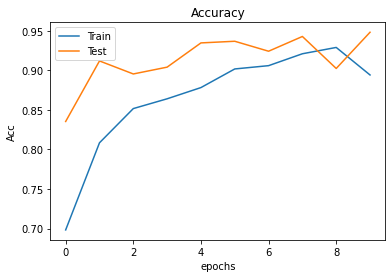

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns

# plt.figure()
# plt.plot(history.history["accuracy"], label = "Train")
# plt.plot(history.history["val_accuracy"], label = "Test")
# plt.title("Accuracy")
# plt.ylabel("Acc")
# plt.xlabel("epochs")
# plt.legend()
# plt.show()



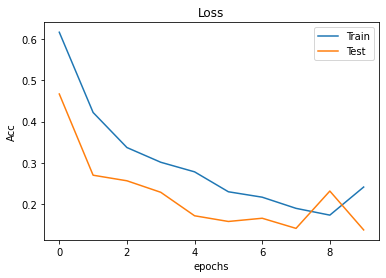

In [ ]:
# plt.figure()
# plt.plot(history.history["loss"], label = "Train")
# plt.plot(history.history["val_loss"], label = "Test")
# plt.title("Loss")
# plt.ylabel("Acc")
# plt.xlabel("epochs")
# plt.legend()
# plt.show()